Assignment 3: Classifcation of Text Data

Team Name

Alex Pham, Matt Manolov, Zakie Shah

COMP 4630

# Starter Code
Here's some BigQuery related stuff and a terrible network to get you started.

## Load the BigQuery data
I highly recommend using [Colab](https://colab.research.google.com/) for this assignment, as it involves some hefty computation. If you have a GPU that you've managed to convince Tensorflow to work with, you can also use the [BigQuery Python client library](https://cloud.google.com/bigquery/docs/reference/libraries#client-libraries-install-python) to load the data.

The following cell assumes you are using Colab and will prompt you for your Google credentials. You will need to activate the BigQuery API for your account first.


In [ ]:
# Assignment 3: Assignment 3: Classification of Text Data
# Team Name
# Matt Manolov, Alex Pham, Zakie Shah
# Comp 4630 - 001

In [ ]:
from google.cloud import bigquery
from google.colab import auth

auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
# python
# Import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from google.cloud import bigquery


To get started with the BigQuery API, do the following:
1. Create a project in the [Google Cloud Console](https://console.cloud.google.com/). The free tier provides up to 1TB of querying per month, so you should be fine, but you can also claim the free credit provided for this course (see instructions on D2L under "Course Info").
2. Enable the BigQuery API for your project.
3. Change the `"<your project id here>"` placeholder in the next cell to the project ID from your Google Cloud Console (probably a slugified version of your project name).

Here I'm loading 10k random rows from the [Stack Overflow dataset](https://console.cloud.google.com/marketplace/details/stack-exchange/stack-overflow), and limiting the selection to questions with a single tag taken from the top 10 most common tags.

For your assignment you'll probably want to bump that number up to at least 100k (don't go too crazy though)!

In [ ]:
project_id = "asg3-453717"

The following cell needs to be run without any Python in it, but it will produce a Pandas dataframe named `df`.

In [ ]:
%%bigquery df --project $project_id
SELECT title, tags
FROM `bigquery-public-data.stackoverflow.posts_questions` as Posts
WHERE ARRAY_LENGTH(SPLIT(Posts.tags, '|')) = 1 AND tags in (
  SELECT tags
  FROM `bigquery-public-data.stackoverflow.posts_questions` as Posts
  WHERE ARRAY_LENGTH(SPLIT(Posts.tags, '|')) = 1
  GROUP BY tags
  ORDER BY COUNT(*) DESC
  LIMIT 10
)
ORDER BY RAND()
LIMIT 200000 #changed to 200k

Query is running:   0%|          |

Downloading:   0%|          |

,title,tags
0,While loop to write in several text files,python
1,Convert into database date in java,java
2,"Error in na.fail.default (list(Training = c(""y...",r
3,Didnot override hashCode() and equals() method...,java
4,Having trouble using cURL's PUT in PHP,php


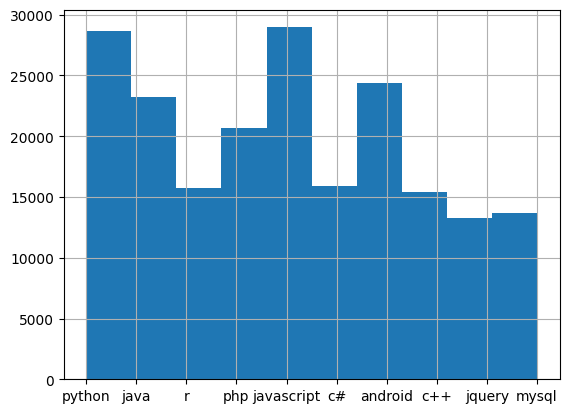

In [ ]:
# Look at the distribution of tags
df['tags'].hist()

# Look at the first five rows of the dataframe
df.head()

You might want to do some class balancing or some other preprocessing, but you'll definitely need to do the following:
1. Split the data into training/validation/testing sets
2. Encode the labels as integers or one-hot vectors (there's lots of ways - I chose to use Pandas' `get_dummies` function)
3. Define a `TextVectorization` layer to normalize, split, and map strings to integers - don't forget to take care of the padding values, either by masking or using `RaggedTensor`s
4. Define some kind of model, hopefully better than the one I use as an example

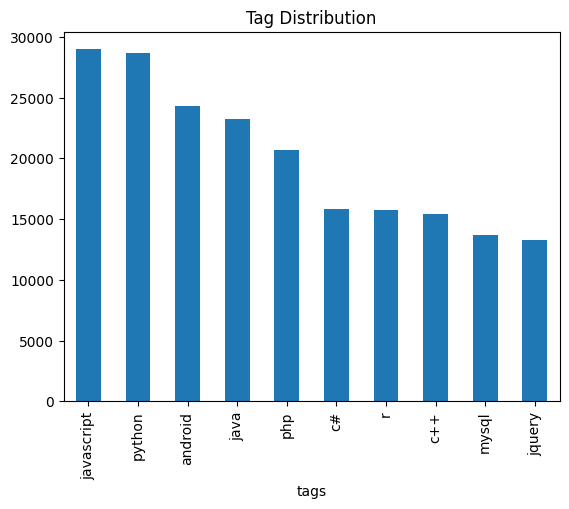

In [ ]:
# Plot a bar chart showing the distribution of values in the "tags" column
import matplotlib.pyplot as plt

df["tags"].value_counts().plot(kind="bar")
plt.title("Tag Distribution")
plt.show()

In [ ]:
# Upsample each class in the "tags" column to match the size of the largest class

from sklearn.utils import resample

#Some upsampling
max_count = df["tags"].value_counts().max()

df_balanced = pd.concat([
    resample(df[df["tags"] == tag],
             replace=True,
             n_samples=max_count,
             random_state=42)
    for tag in df["tags"].unique()
])

# shuffling and resetting the index
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# checking that each class has the same count
print(df_balanced["tags"].value_counts())


tags
php           28966
r             28966
python        28966
jquery        28966
javascript    28966
java          28966
c#            28966
android       28966
c++           28966
mysql         28966
Name: count, dtype: int64


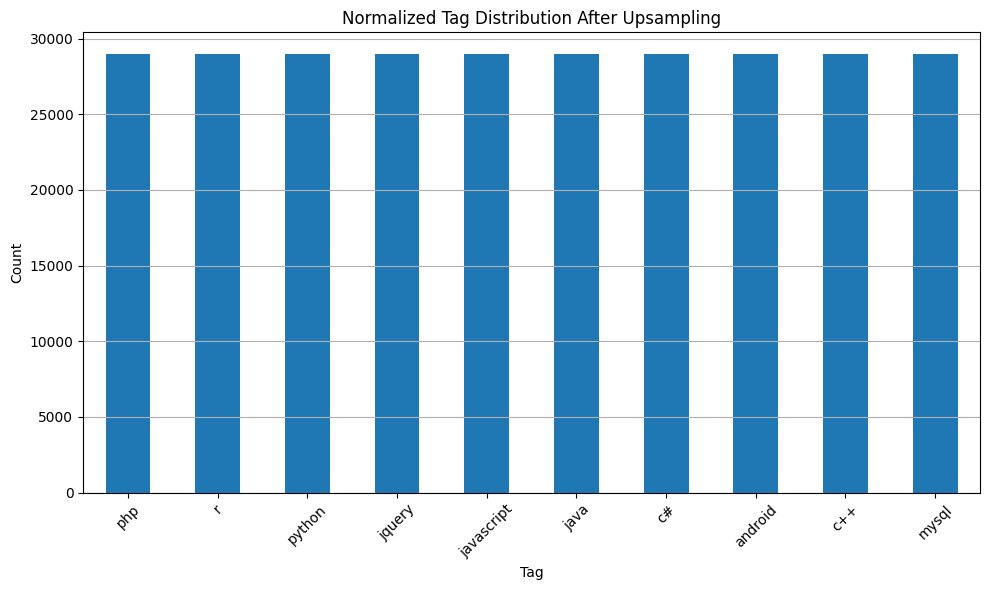

In [ ]:
# Visualize the distribution of tag classes after upsampling to ensure all classes are equally represented

import pandas as pd
import matplotlib.pyplot as plt

tag_counts = df_balanced["tags"].value_counts()

plt.figure(figsize=(10, 6))
tag_counts.plot(kind="bar")
plt.title("Normalized Tag Distribution After Upsampling")
plt.xlabel("Tag")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y')
plt.show()


In [ ]:
# Convert categorical "tags" column into one-hot encoded labels and store the label names

labels = pd.get_dummies(df_balanced["tags"])
label_names = labels.columns.tolist()


In [ ]:
# data cleaning
# Clean the "title" column: lowercase, remove punctuation, numbers, and extra whitespace

import string
import re


df_balanced["title"] = (
    df_balanced["title"]
    .str.lower()
    .str.translate(str.maketrans('', '', string.punctuation))
    .str.replace(r'\d+', '', regex=True)  #For numbers
    .str.strip() # This is for the whitespace
)


In [ ]:
# Split the balanced dataset into training (70%), validation (15%), and test (15%) sets,
# and one-hot encode the labels for each split

import pandas as pd

# train/validation/test split (70/15/15)
tv_thresh = int(0.7 * len(df_balanced))
vt_thresh = int(0.85 * len(df_balanced))

# spilt the data
train_X = df_balanced["title"][:tv_thresh].values
val_X = df_balanced["title"][tv_thresh:vt_thresh].values
test_X = df_balanced["title"][vt_thresh:].values

# encode the labels
labels = pd.get_dummies(df_balanced["tags"])
label_names = labels.columns

train_y = labels[:tv_thresh].values
val_y = labels[tv_thresh:vt_thresh].values
test_y = labels[vt_thresh:].values

# # checking the sizes before training
# print(f"train_X: {train_X.shape}, train_y: {train_y.shape}")
# print(f"val_X: {val_X.shape}, val_y: {val_y.shape}")
# print(f"test_X: {test_X.shape}, test_y: {test_y.shape}")

# # just checking to see if input sizes match
# assert len(train_X) == len(train_y), "Mismatch in training data!"
# assert len(val_X) == len(val_y), "Mismatch in validation data!"
# assert len(test_X) == len(test_y), "Mismatch in test data!"


train_X: (202762,), train_y: (202762, 10)
val_X: (43449,), val_y: (43449, 10)
test_X: (43449,), test_y: (43449, 10)


In [ ]:
# Create and fit a TextVectorization layer to convert text titles into sequences of integers

from tensorflow.keras.layers import TextVectorization

vec_layer = TextVectorization(
    max_tokens=10000,
    output_mode='int',
    output_sequence_length=100
)

# fit vectorizer on all titles
vec_layer.adapt(df_balanced["title"].values)


In [ ]:
# Vectorize the title text data for training, validation, and testing using the fitted vectorizer

train_X_vec = vec_layer(train_X)
val_X_vec = vec_layer(val_X)
test_X_vec = vec_layer(test_X)


In [ ]:
# Building a simple neural network for multi-class text classification using an embedding layer and average pooling
# Embedding layer for word vectorization,
# GlobalAveragePooling1D for fixed-size representation
# Dropout for regularization and to speed up the algorithm
# Dense layers for learning non-linear patterns, and softmax for multi-class prediction.

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout

num_classes = train_y.shape[1]  # still using one-hot encoded labels

model = Sequential([
    Embedding(input_dim=10000, output_dim=64, mask_zero=True),
    GlobalAveragePooling1D(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])



In [ ]:
# use this to save the keras model in google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Train the model with early stopping to prevent overfitting, then wrap it with the text vectorizer
# to create an end-to-end model that can take raw text input and have it saved.

from tensorflow.keras.callbacks import EarlyStopping

# Stop training if validation loss doesn't improve for 3 consecutive epochs
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.compile(
    loss='categorical_crossentropy', # suitable for multi-class classification with one-hot encoded label
    optimizer='adam',                # adaptive optimizer that adjusts learning rate during training
    metrics=['accuracy']             # tracks the percentage of correct predictions during training/validation
)

history = model.fit(
    x=train_X_vec,
    y=train_y,
    validation_data=(val_X_vec, val_y),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop]
)

input_layer = tf.keras.Input(shape=(1,), dtype=tf.string)
x = vec_layer(input_layer)
x = model(x)
full_model = tf.keras.Model(inputs=input_layer, outputs=x)

full_model.save("/content/drive/MyDrive/final_model.keras")

Epoch 1/20
6337/6337 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.8308 - loss: 0.4917 - val_accuracy: 0.8125 - val_loss: 0.5991
Epoch 2/20
6337/6337 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.8308 - loss: 0.4888 - val_accuracy: 0.8136 - val_loss: 0.5996
Epoch 3/20
6337/6337 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.8355 - loss: 0.4819 - val_accuracy: 0.8139 - val_loss: 0.6002
Epoch 4/20
6337/6337 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.8330 - loss: 0.4825 - val_accuracy: 0.8163 - val_loss: 0.5984
Epoch 5/20
6337/6337 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.8366 - loss: 0.4775 - val_accuracy: 0.8162 - val_loss: 0.5977
Epoch 6/20
6337/6337 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.8371 - loss: 0.4773 - val_accuracy: 0.8171 - val_loss: 0.5962
Epoch 7/20
6337/6337 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.8383 - loss: 0.4735 - val_accuracy: 0.8183 - val_loss: 0.5962
Epoch 8/20
6337/6337 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.8393 - loss: 0

In [ ]:
# Just getting some numbers on the model. Evaluating the model's performance on the test set by reporting accuracy,
# loss, and its printed nicely by including precision, recall, and F1-score for each class

test_loss, test_accuracy = model.evaluate(test_X_vec, test_y, verbose=1)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# getting predicted labels from the test data set
import numpy as np
pred_probs = model.predict(test_X_vec)
pred_labels = np.argmax(pred_probs, axis=1)
true_labels = np.argmax(test_y, axis=1)

# print out the report
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=label_names))


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8235 - loss: 0.5868

Test Accuracy: 0.8205
Test Loss: 0.5897
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Classification Report:
              precision    recall  f1-score   support

     android       0.91      0.90      0.91      4335
          c#       0.69      0.68      0.69      4351
         c++       0.71      0.81      0.76      4352
        java       0.77      0.71      0.74      4259
  javascript       0.78      0.76      0.77      4413
      jquery       0.88      0.90      0.89      4286
       mysql       0.91      0.96      0.93      4334
         php       0.84      0.80      0.82      4320
      python       0.82      0.77      0.79      4404
           r       0.89      0.91      0.90      4395

    accuracy                           0.82     43449
   macro avg       0.82      0.82      0.82     43449
weighted avg       0.82      0.82      0.82     43449



In [ ]:
# Performing some simple testing before we continue.

custom_sentences = [
    "How to fix null pointer exception in android studio",
    "Why is my JavaScript for loop skipping elements?",
    "Importing pandas throws error in python script",
    "Best way to connect C# application to a database",
    "Segmentation fault when overloading operator in C++"
]


custom_vec = vec_layer(np.array(custom_sentences))
pred_probs = model.predict(custom_vec)
pred_indices = np.argmax(pred_probs, axis=1)
pred_tags = label_names[pred_indices]

for i, sentence in enumerate(custom_sentences):
    print(f"\nSentence: {sentence}")
    print(f"Predicted Tag: {pred_tags[i]}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step

Sentence: How to fix null pointer exception in android studio
Predicted Tag: android

Sentence: Why is my JavaScript for loop skipping elements?
Predicted Tag: javascript

Sentence: Importing pandas throws error in python script
Predicted Tag: python

Sentence: Best way to connect C# application to a database
Predicted Tag: c#

Sentence: Segmentation fault when overloading operator in C++
Predicted Tag: c++
